In [1]:
from importlib import reload

import torch
from torch import nn
from torch.utils.data import DataLoader

# %load_ext tensorboard

import dataset, model, trainer
import numpy as np
import util, config, zernike

{3: 0.09568028074692181, 4: -0.15986426547047283, 5: 1.519445815298444, 6: -0.3494663464422657, 7: 0.04431193952758561, 8: 0.2676357045105221, 9: 0.3110416868530429, 10: -0.40610329445709936, 11: 0.3484225475567324, 12: 0.11263242151160135, 13: 0.36457356006941255, 14: 0.3641958036097024, 15: -0.07261153829853972, 16: -0.2786818420377615, 17: 0.08944437142521289, 18: 0.44663521951120433, 19: 0.46734728558092486, 20: 0.13969432238487012}


D:\Github\smlm-dl\smlm_dl\dataset.py:222: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


227:	 [id = 227.000,], [x = 0.851,], [y = -7.768,], [A = 830.988,], [bg = 36.149,],
186:	 [id = 186.000,], [x = 9.002,], [y = 1.710,], [A = 1301.563,], [bg = 37.302,],
202:	 [id = 202.000,], [x = 5.238,], [y = -2.453,], [A = 657.679,], [bg = 68.688,],
161:	 [id = 161.000,], [x = 10.233,], [y = -9.342,], [A = 1608.761,], [bg = 13.646,],
236:	 [id = 236.000,], [x = 1.209,], [y = 5.511,], [A = 1094.535,], [bg = 25.974,],
209:	 [id = 209.000,], [x = -8.683,], [y = -6.798,], [A = 1705.464,], [bg = 15.248,],
141:	 [id = 141.000,], [x = 0.028,], [y = 8.472,], [A = 609.011,], [bg = 30.171,],
132:	 [id = 132.000,], [x = -2.749,], [y = 6.369,], [A = 1587.646,], [bg = 87.982,],
8:	 [id = 8.000,], [x = 2.162,], [y = 6.471,], [A = 1219.001,], [bg = 29.422,],
107:	 [id = 107.000,], [x = 5.505,], [y = -2.237,], [A = 1447.588,], [bg = 1.691,],
168:	 [id = 168.000,], [x = 5.664,], [y = -9.752,], [A = 1080.564,], [bg = 99.877,],
237:	 [id = 237.000,], [x = -9.912,], [y = -0.514,], [A = 1026.795,], [bg =

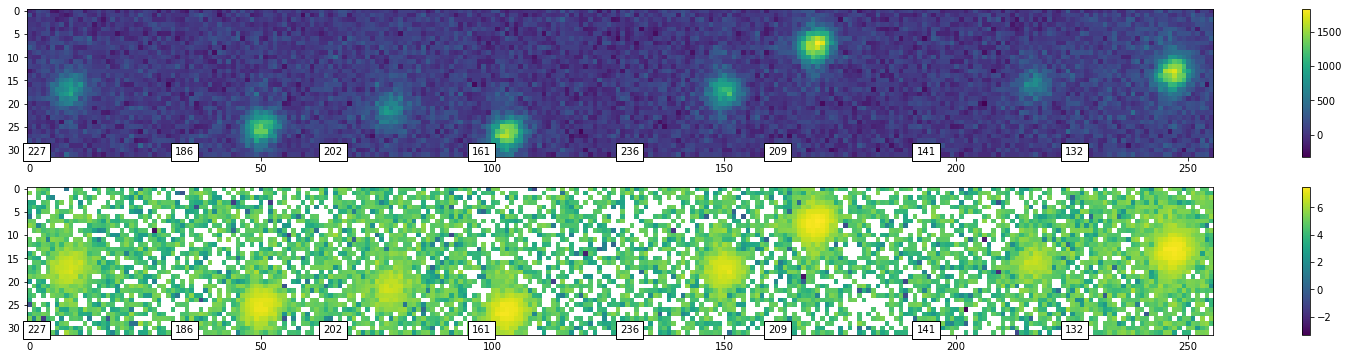

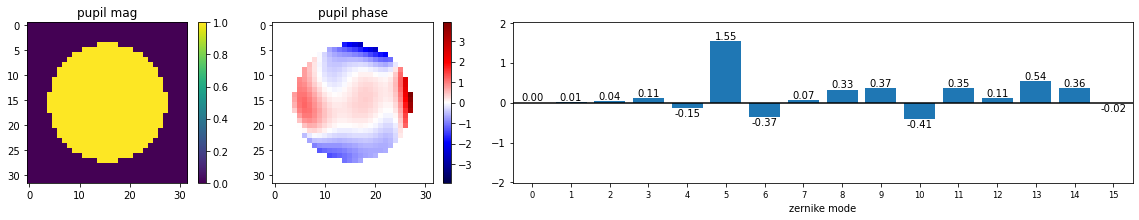

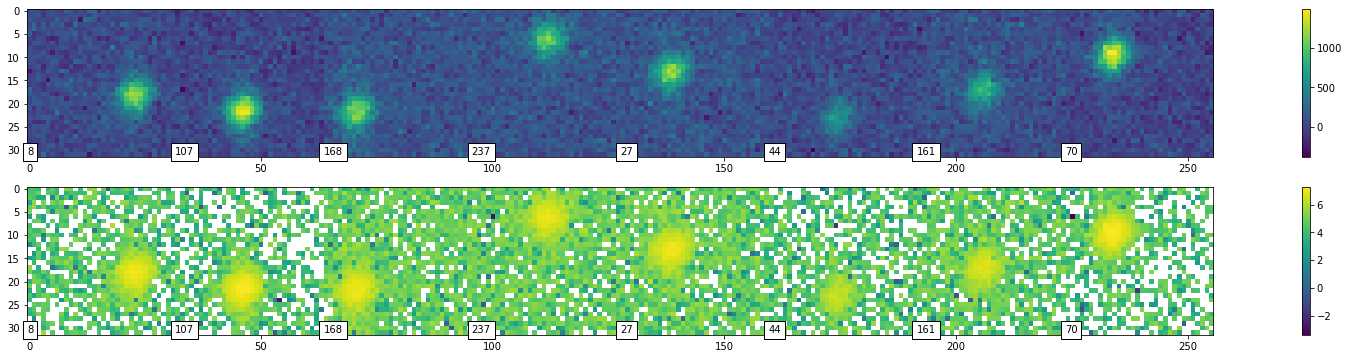

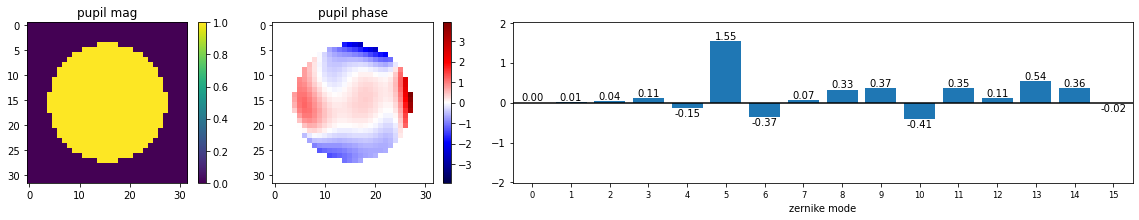

In [2]:
reload(dataset)

psf_zerns = dict()
for z in range(3, 21):
    psf_zerns[z] = np.random.uniform(-0.5, 0.5)
# psf_zerns.update({4:1, 5:2, 7:1, 12:0.5, })
# psf_zerns.update({5:2 })
psf_zerns[5] = np.random.uniform(0.5, 2.5)

print(psf_zerns)

settings = {
    # 'out_size': (64,64),
    'length': (256, 1),
    'dropout_p': 0,
    'psf_zerns': psf_zerns,
    # 'noise_params': {},
    'normalize': False,
    'padding': (4,4),
    'random_z': False,
    "augmentations":{},
    # "augmentations":{"pixel shift":(4,4), }#"add noise":0.1},
}

# training_data = dataset.FourierOptics2DPSFDataset(**settings)
# training_data = dataset.Gaussian2DPSFDataset(**settings)
training_data = dataset.FourierOpticsPSFDataset(**settings)

dataset.inspect_images(training_data)

train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)


# valid_data = dataset.FourierOptics2DPSFDataset(**settings)
# valid_data = dataset.Gaussian2DPSFDataset(**settings)
valid_data = dataset.FourierOpticsPSFDataset(**settings)
dataset.inspect_images(valid_data)

valid_dataloader = DataLoader(valid_data, batch_size=256, shuffle=True)
valid_dataloader = train_dataloader

In [3]:
fit_params = ['x','y','sig','A','bg']
init_params = np.zeros((len(fit_params), len(train_dataloader.dataset), ))
print(init_params.shape)
init_params[0] = training_data.params['x'][:,0] * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
init_params[1] = training_data.params['y'][:,0] * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
init_params[2] = 5 * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
init_params[3] = training_data.params['A'][:,0] * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
init_params[4] = training_data.params['bg'] * np.random.uniform(0.9, 1.0, len(train_dataloader.dataset))
print(init_params[:,0])

(5, 256)
[-1.08894617e+00  1.34592036e-01  4.62845109e+00  1.80638464e+03
  2.79251243e+00]


(5, 256)
torch.Size([5, 256])
{'x': [<act: Identity, offset: 0, scaling: 1, default: 0.0, per psf: True, >], 'y': [<act: Identity, offset: 0, scaling: 1, default: 0.0, per psf: True, >], 'sig': [<act: Identity, offset: 0, scaling: 1, default: 7, per psf: True, >], 'A': [<act: Identity, offset: 0, scaling: 1, default: 1000, per psf: True, >], 'bg': [<act: Identity, offset: 0, scaling: 1, default: 0, per psf: False, >]}
CUDA not available. Defaulting to CPU
Device: cpu


C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


input shape: torch.Size([256, 1, 32, 32]), output_shape: (256, 1, 32, 32)


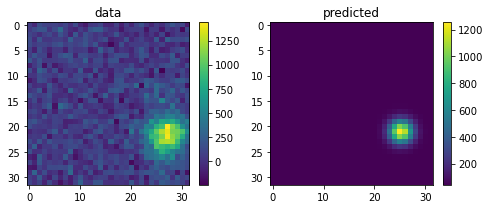

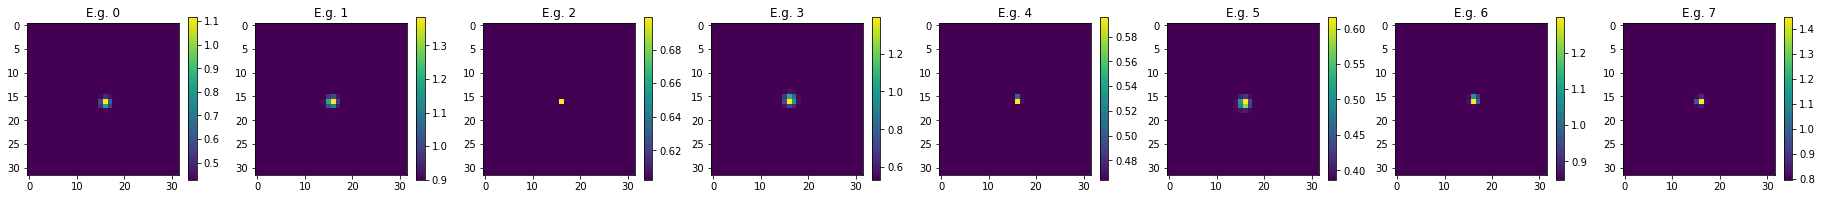

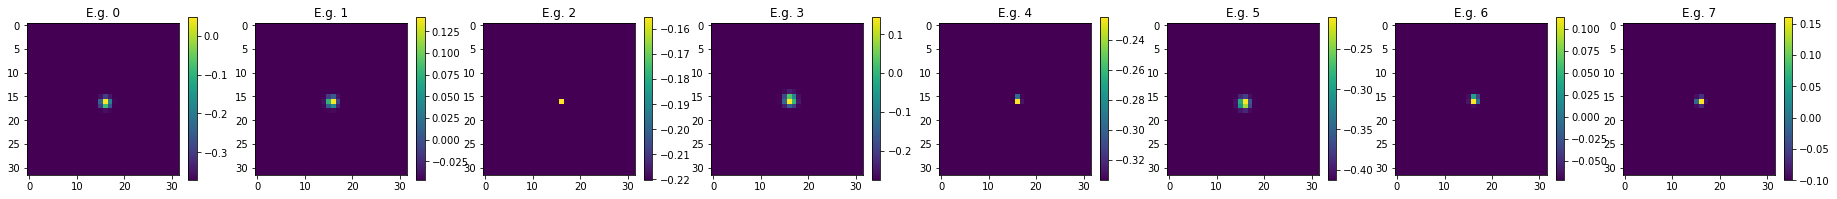

In [4]:
reload(trainer)
reload(model)
reload(util)
reload(zernike)

# params_ref_override = {
#     'x': model.FitParameter(nn.Hardtanh(), 0, 24, 0, True),
#     'y': model.FitParameter(nn.Hardtanh(), 0, 24, 0, True),
#     'A': model.FitParameter(nn.ReLU(), 0, 1000, 1, True),
#     'bg': model.FitParameter(nn.Tanh(), 0, 500, 0, False),
# }

# fitting_model = model.Gaussian2DModel(fit_params=['x','y','A','bg','sig',], max_psf_count=1, depth=3, skip_channels=0)

# sig_param = model.FitParameter(nn.ReLU(), 2, 1, 20, True)
# fitting_model = model.Gaussian2DModel(fit_params=['x','y','A','bg'], params_ref_override={'sig':sig_param}, max_psf_count=3)

# fitting_model = model.Template2DModel(
                                    # feedback_class=model.DirectConcatFeedbackModel,
                                    # feedback_class=model.DenseFeedbackModel,
                                     #  fit_params=['x','y','A','bg'],
                                     #  max_psf_count=1,
                                     # params_ref_override=params_ref_override,
                                     # )
# fitting_model =  model.FourierOptics2DModel(
#                                             feedback_class=model.DenseFeedbackModel,
#                                             # feedback_class=model.DirectConcatFeedbackModel,
#                                             img_size=(32,32),
#                                             fit_params=['x','y','z','A','bg'],
#                                             max_psf_count=1,
#                                             params_ref_override=params_ref_override,
#                                             encoder_params={"skip_channels":0},
#                                             renderer_params={"pupil_params":{'scale':0.75, 'apod':False, },}#'phase_init_zern':{5:2}},
#                                             )

fitting_model = model.Gaussian2DModel(encoder_class=model.IdEncoderModel,
                                      # img_size=(32,32),
                                      fit_params=fit_params,
                                      max_psf_count=1,
                                      encoder_params={"num_img":len(train_dataloader.dataset),
                                                      "init_weights":init_params,
                                          # "depth":3,
                                                      # "skip_channels":4,
                                                      # "first_layer_out_channels":16,
                                                     },
                                      params_ref_no_scale=True,
                                     )

print(fitting_model.fit_params)

# optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=1e4)
optimizer = torch.optim.Adam(fitting_model.parameters(), lr=1e0)
# optimizer = torch.optim.SGD(fitting_model.parameters(), lr=1e-4)
# optimizer = torch.optim.LBFGS(fitting_model.parameters(), lr=1e-4)



# model_parameters = [param for param in fitting_model.parameters()
#                     # if (not param is fitting_model.renderer.template.parameter)]
#                     if (not param is fitting_model.renderer.pupil_magnitude.parameter) and 
#                     (not param is fitting_model.renderer.pupil_phase.parameter)]
# # print(model_parameters)

# optimizer = torch.optim.Adam([{"params" : fitting_model.encoder.parameters()},
#                               # {"params" : fitting_model.feedbacker.parameters(), "lr" : 1e-3},
#                               {"params" : fitting_model.renderer.parameters(), "lr" : 1e-2},
#                              ], lr=1e-3)


training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer)
!
# training.train_single_epoch()
# training.validate()

model.check_model(fitting_model, train_dataloader)

In [5]:
# training.load_checkpoint(r"D:\Github\smlm-dl\smlm_dl\checkpoints\Nov19_20-27-37_DESKTOP-7NNT713.ptc")

Saved to : D:\Pytorch\runs\2021-12-10_18-56-54_DESKTOP-7NNT713_dFit_test\model.ptm
Starting training Epoch # 0
Epoch # 0, Batch # 0 (256/256), loss = 26791.281250
****************************************************************************************************
Validation, average loss = 21489.595703
****************************************************************************************************
Starting training Epoch # 1
Epoch # 1, Batch # 0 (256/256), loss = 21489.597656
****************************************************************************************************
Validation, average loss = 19644.517578
****************************************************************************************************
Starting training Epoch # 2
Epoch # 2, Batch # 0 (256/256), loss = 19644.515625
****************************************************************************************************
Validation, average loss = 17504.228516
****************************************************

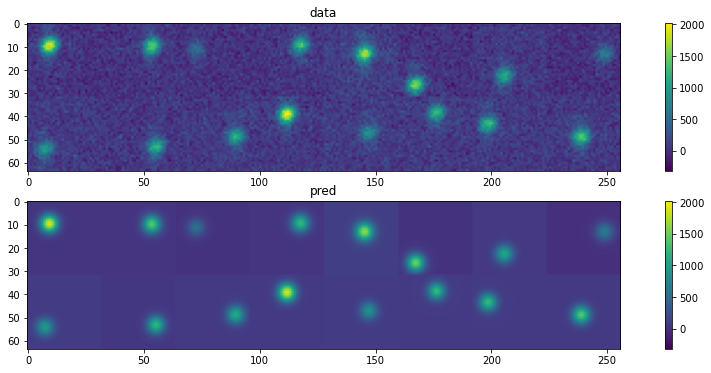

In [6]:
# from torch.utils.tensorboard import SummaryWriter
# training.train_and_validate(1000000, tb_logger=SummaryWriter())

training.train_and_validate(100, training_interval=1, validate_interval=1, label="dFit_test")
# training.train_single_epoch()
# training.validate()

input shape: torch.Size([256, 1, 32, 32]), output_shape: (256, 1, 32, 32)


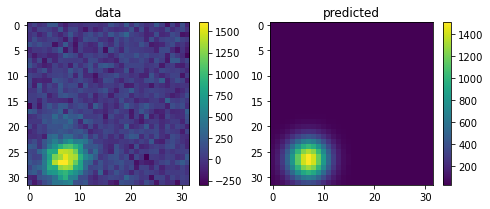

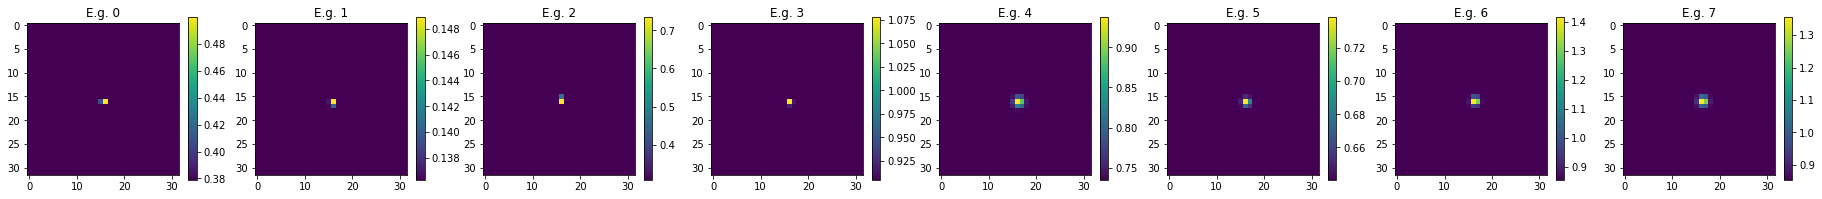

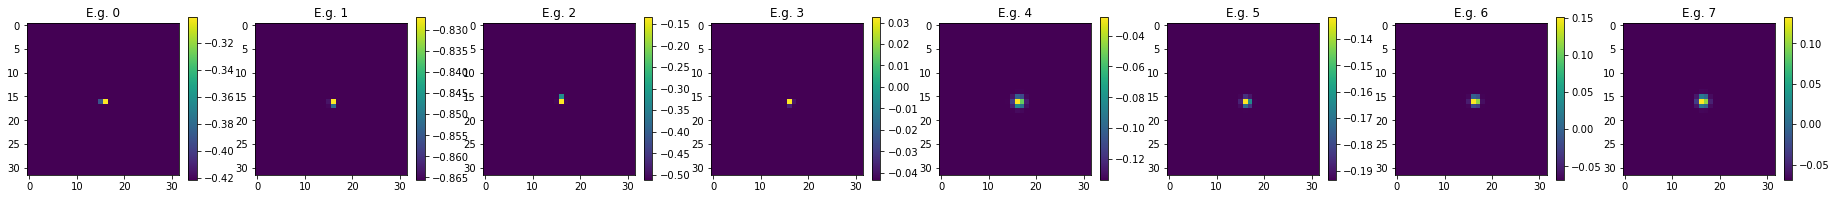

In [7]:
model.check_model(fitting_model, train_dataloader)
